# Necessities

In [1]:
# ------------------------------------------------------------------
# Imports
# ------------------------------------------------------------------
# Basic data processing libraries
import pandas as pd
import numpy as np
import os
import torch

# Graph data processing libraries
import networkx as nx
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx

# Libraries for (G)NNs
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
import torch.nn as nn

# ------------------------------------------------------------------
# Helper functions
# ------------------------------------------------------------------
def show_df_info(df):
    print(df.info())
    print('####### Repeat ####### \n', df.duplicated().any())
    print('####### Count ####### \n', df.nunique())
    print('####### Example ####### \n',df.head())

def label_statics(label_df, label_list):
    print("####### nCount #######")
    for label in label_list:
        print(label_df[label].value_counts())
    print("####### nPercent #######")
    for label in label_list:
        print(label_df[label].value_counts()/label_df.shape[0])

# ------------------------------------------------------------------
# Data stuff
# ------------------------------------------------------------------
base_path = os.getcwd()
input_ali_data_path = os.path.join(base_path, "input_ali_data")

# Load the data files
user_labels_path = os.path.join(input_ali_data_path, "user_labels.csv")
user_edges_path = os.path.join(input_ali_data_path, "user_edge.csv")

# Create dataframes to store the information from the .csv files
user_labels = pd.read_csv(user_labels_path)
user_edges = pd.read_csv(user_edges_path)

## Balancing the dataset

In [107]:
# Count the number of instances for each gender
gender_counts = user_labels['gender'].value_counts()
print(gender_counts)

# Find the minimum count between the two genders
min_count = min(gender_counts)
print(min_count)

# Sample an equal number of instances for each gender
balanced_data = pd.concat([
    user_labels[user_labels['gender'] == 1].sample(min_count),
    user_labels[user_labels['gender'] == 0].sample(min_count)
])

# Reset the index of the balanced data
balanced_data.reset_index(drop=True, inplace=True)

# Update the user_labels dataframe with the balanced data
filtered_user_labels = balanced_data


bin_age
0    95375
1    71583
Name: count, dtype: int64
71583


In [108]:
print(balanced_data)

           uid  gender  age  buy  student  city  bin_age  bin_buy
0       156829       0    2    1        1     0        1        1
1        87623       1    2    0        1     0        1        0
2        21014       0    1    1        1     0        1        1
3        60909       0    3    1        1     2        1        1
4        60957       1    3    1        1     1        1        1
...        ...     ...  ...  ...      ...   ...      ...      ...
143161   56205       1    0    1        0     0        0        1
143162  144496       0    0    1        1     0        0        1
143163   38241       0    4    1        1     0        0        1
143164   85503       1    0    0        1     3        0        0
143165  158306       0    0    0        1     3        0        0

[143166 rows x 8 columns]


In [3]:
show_df_info(filtered_user_labels)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84384 entries, 0 to 84383
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   uid      84384 non-null  int64
 1   gender   84384 non-null  int64
 2   age      84384 non-null  int64
 3   buy      84384 non-null  int64
 4   student  84384 non-null  int64
 5   city     84384 non-null  int64
 6   bin_age  84384 non-null  int64
 7   bin_buy  84384 non-null  int64
dtypes: int64(8)
memory usage: 5.2 MB
None
####### Repeat ####### 
 False
####### Count ####### 
 uid        84384
gender         2
age            7
buy            3
student        2
city           4
bin_age        2
bin_buy        2
dtype: int64
####### Example ####### 
       uid  gender  age  buy  student  city  bin_age  bin_buy
0   75862       1    2    1        1     0        1        1
1  147011       1    4    1        1     0        0        1
2   94599       1    0    1        1     0        0        1
3   63085      

In [4]:
label_statics(filtered_user_labels, filtered_user_labels.columns[1:])

####### nCount #######
gender
1    42192
0    42192
Name: count, dtype: int64
age
4    25242
3    20932
0    16695
2    16263
5     3657
1     1563
6       32
Name: count, dtype: int64
buy
1    51060
0    26334
2     6990
Name: count, dtype: int64
student
1    79101
0     5283
Name: count, dtype: int64
city
0    37372
3    20593
2    17525
1     8894
Name: count, dtype: int64
bin_age
0    45626
1    38758
Name: count, dtype: int64
bin_buy
1    58050
0    26334
Name: count, dtype: int64
####### nPercent #######
gender
1    0.5
0    0.5
Name: count, dtype: float64
age
4    0.299133
3    0.248057
0    0.197846
2    0.192726
5    0.043338
1    0.018522
6    0.000379
Name: count, dtype: float64
buy
1    0.605091
0    0.312073
2    0.082836
Name: count, dtype: float64
student
1    0.937393
0    0.062607
Name: count, dtype: float64
city
0    0.442880
3    0.244039
2    0.207682
1    0.105399
Name: count, dtype: float64
bin_age
0    0.540695
1    0.459305
Name: count, dtype: float64
bin_buy
1 

In [60]:
user_edges

,uid1,uid2
0,118017,118017
1,118017,42978
2,118017,6673
3,118017,33244
4,118017,42163
...,...,...
29061401,110307,138408
29061402,110307,4433
29061403,110307,33589
29061404,151118,62924


In [109]:
# Filter the edges based on the remaining nodes in user_labels
filtered_edges = user_edges[(user_edges['uid1'].isin(filtered_user_labels.index)) & (user_edges['uid2'].isin(filtered_user_labels.index))]
filtered_edges = filtered_edges.reset_index(drop=True)

# Update the edge_index variable with the filtered edges
edge_index = torch.tensor(filtered_edges.values, dtype=torch.long).t().contiguous()
edge_index

tensor([[118017, 118017, 118017,  ..., 110307, 110307, 110307],
        [118017,  42978,   6673,  ..., 138408,   4433,  33589]])

## Continue Data Prep

In [2]:
# Prepare the data for GNNs
node_features = torch.tensor(user_labels.iloc[:, 1:].values, dtype=torch.float)
edge_index = torch.tensor(user_edges.values, dtype=torch.long).t().contiguous()

# node_features = torch.tensor(filtered_user_labels.iloc[:, 1:].values, dtype=torch.float)
# edge_index = torch.tensor(filtered_edges.values, dtype=torch.long).t().contiguous()

# Create torch-geometric data
data = Data(x=node_features, edge_index=edge_index)

num_nodes = node_features.size(0)
num_classes = 2 # Binarised gender values from the data
num_node_features = data.num_node_features

# Create masks for training, and testing
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)

# 80 - 20 Train and Test data split
num_train = int(num_nodes * 0.9)
train_mask[:num_train] = True
test_mask[num_train:] = True

data.train_mask = train_mask
data.test_mask = test_mask

# Labels from the data (in this case: Gender Classification)
data.y = torch.tensor(user_labels['gender'].values, dtype=torch.long)
# data.y = torch.tensor(filtered_user_labels['gender'].values, dtype=torch.long)
# data.y = torch.tensor(filtered_user_labels['bin_age'].values, dtype=torch.long)

In [3]:
print(data, num_nodes, train_mask.size(), test_mask.size())

Data(x=[166958, 7], edge_index=[2, 29061406], train_mask=[166958], test_mask=[166958], y=[166958]) 166958 torch.Size([166958]) torch.Size([166958])


# Loss Functions

In [3]:
def fairness_aware_loss(output, data, sensitive_attr, alpha=0, beta=0, gamma=0, delta=0):
    target = data.y[data.train_mask]
    standard_loss = F.cross_entropy(output, target)

    labels = data.y[train_mask]
    pos_prob = torch.sigmoid(output[:, 1])
    neg_prob = 1 - pos_prob
    predictions = output.argmax(dim=1)

    # Statistical Parity Regularization
    sp_reg = torch.abs(pos_prob[sensitive_attr == 1].mean() - pos_prob[sensitive_attr == 0].mean())

    # Calculating FPR and TPR for each group
    fpr_group1 = ((predictions == 1) & (labels == 0) & (sensitive_attr == 1)).float().mean()
    fpr_group0 = ((predictions == 1) & (labels == 0) & (sensitive_attr == 0)).float().mean()
    tpr_group1 = ((predictions == 1) & (labels == 1) & (sensitive_attr == 1)).float().mean()
    tpr_group0 = ((predictions == 1) & (labels == 1) & (sensitive_attr == 0)).float().mean()

    # Difference in FPR and TPR between the two groups for Equalized Odds
    fpr_diff = torch.abs(fpr_group1 - fpr_group0)
    tpr_diff = torch.abs(tpr_group1 - tpr_group0)

    # Combine FPR and TPR differences for Equalized Odds Regularization
    equalized_odds_reg = fpr_diff + tpr_diff

    # Treatment Equality Regularization
    fp_diff = (neg_prob * (labels == 0) * (sensitive_attr == 1)).float().mean() - \
              (neg_prob * (labels == 0) * (sensitive_attr == 0)).float().mean()
    fn_diff = (pos_prob * (labels == 1) * (sensitive_attr == 1)).float().mean() - \
              (pos_prob * (labels == 1) * (sensitive_attr == 0)).float().mean()
    treatment_reg = torch.abs(fp_diff) + torch.abs(fn_diff)
    # treatment_reg = torch.abs(fn_diff)

    # fn_group_1 = ((predictions == 0) & (labels == 1) & (sensitive_attr == 1)).sum()
    # fp_group_1 = ((predictions == 1) & (labels == 0) & (sensitive_attr == 1)).sum()

    # fn_group_0 = ((predictions == 0) & (labels == 1) & (sensitive_attr == 0)).sum()
    # fp_group_0 = ((predictions == 1) & (labels == 0) & (sensitive_attr == 0)).sum()
    
    # ratio_group_1 = fn_group_1 / fp_group_1 if fp_group_1 != 0 else torch.tensor(float('inf'))
    # ratio_group_0 = fn_group_0 / fp_group_0 if fp_group_0 != 0 else torch.tensor(float('inf'))
    # treatment_reg = torch.abs(ratio_group_1 - ratio_group_0)

    # Equal Opportunity Difference Regularization
    eod_reg = torch.abs((pos_prob * (labels == 1) * (sensitive_attr == 1)).float().mean() - \
                        (pos_prob * (labels == 1) * (sensitive_attr == 0)).float().mean())

    # Overall Accuracy Equality Difference Regularization
    oaed_reg = torch.abs((pos_prob * (sensitive_attr == 1)).float().mean() - \
                         (pos_prob * (sensitive_attr == 0)).float().mean())

    penalty = alpha + beta + gamma + delta
    
    # Combine losses
    combined_loss = (1-penalty)*standard_loss
    + alpha * equalized_odds_reg
    + beta * treatment_reg
    + gamma * eod_reg
    + delta * oaed_reg
    
    return combined_loss

# Calculate Fairness

In [4]:
def calculate_fairness(label, predictions, sens_attr='bin_age', balanced=False):
    """
    Calculate various fairness metrics.

    Args:
    label: Actual labels (binary).
    predictions: Model predictions (binary).
    sens_attr: Binary sensitive attribute for fairness evaluation.

    Returns:
    A dictionary containing SPD, EOD, OAED, and TED values.
    """
    if balanced is False:
        labels = torch.tensor(user_labels[label].values, dtype=torch.long)
        sensitive_attribute = torch.tensor(user_labels[sens_attr].values, dtype=torch.long)
    else:
        labels = torch.tensor(filtered_user_labels[label].values, dtype=torch.long)
        sensitive_attribute = torch.tensor(filtered_user_labels[sens_attr].values, dtype=torch.long)

    predictions = predictions.float()
    labels = labels.float()
    sensitive_attribute = sensitive_attribute.float()

    def statistical_parity_difference():
        prob_group_1 = predictions[sensitive_attribute == 1].mean()
        prob_group_0 = predictions[sensitive_attribute == 0].mean()
        return abs(prob_group_1 - prob_group_0), prob_group_0, prob_group_1

    def equal_opportunity_difference():
        tpr_group_1 = predictions[(labels == 1) & (sensitive_attribute == 1)].mean()
        tpr_group_0 = predictions[(labels == 1) & (sensitive_attribute == 0)].mean()
        return abs(tpr_group_1 - tpr_group_0), tpr_group_0, tpr_group_1

    def overall_accuracy_equality_difference():
        acc_group_1 = (predictions[sensitive_attribute == 1] == labels[sensitive_attribute == 1]).float().mean()
        acc_group_0 = (predictions[sensitive_attribute == 0] == labels[sensitive_attribute == 0]).float().mean()
        return abs(acc_group_1 - acc_group_0), acc_group_0, acc_group_1

    def treatment_equality_difference():
        fn_group_1 = ((predictions == 0) & (labels == 1) & (sensitive_attribute == 1)).sum()
        fp_group_1 = ((predictions == 1) & (labels == 0) & (sensitive_attribute == 1)).sum()

        fn_group_0 = ((predictions == 0) & (labels == 1) & (sensitive_attribute == 0)).sum()
        fp_group_0 = ((predictions == 1) & (labels == 0) & (sensitive_attribute == 0)).sum()

        ratio_group_1 = fn_group_1 / fp_group_1 if fp_group_1 != 0 else float('inf')
        ratio_group_0 = fn_group_0 / fp_group_0 if fp_group_0 != 0 else float('inf')

        return abs(ratio_group_1 - ratio_group_0), ratio_group_0, ratio_group_1, fn_group_1, fp_group_1, fn_group_0, fp_group_0

    # Calculating each fairness metric
    spd, sp_g0, sp_g1 = statistical_parity_difference()
    eod, eod_g0, eod_g1 = equal_opportunity_difference()
    oaed, oaed_g0, oaed_g1 = overall_accuracy_equality_difference()
    ted, ted_g0, ted_g1, fn_group_1, fp_group_1, fn_group_0, fp_group_0 = treatment_equality_difference()

    return {
        'Statistical Parity Difference': spd,
        'Statistical Parity Group with S=0': sp_g0,
        'Statistical Parity Group S=1': sp_g1,
        'Equal Opportunity Difference': eod,
        'Equal Opportunity Group with S=0': eod_g0,
        'Equal Opportunity Group S=1': eod_g1,
        'Overall Accuracy Equality Difference': oaed,
        'Overall Accuracy Group with S=0': oaed_g0,
        'Overall Accuracy Group S=1': oaed_g1,
        'Treatment Equality Difference': ted,
        'Treatment Equality Group with S=0': ted_g0,
        'Treatment Equality Group S=1': ted_g1,
        'False Negatives Group 1': fn_group_1,
        'False Positives Group 1': fp_group_1,
        'False Negatives Group 0': fn_group_0,
        'False Positives Group 0': fp_group_0
    }

# Helper functions

In [5]:
# Train the model
def training(model, data, optimizer, epochs, fairness=False, alpha=0, beta=0, gamma=0, delta=0):

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        
        if fairness:
            loss = fairness_aware_loss(out[data.train_mask], data, data.x[data.train_mask, -1],
                                       alpha=alpha, beta=beta, gamma=gamma, delta=delta)
            
        else:
            # criterion = torch.nn.CrossEntropyLoss()
            # criterion = torch.nn.BCELoss()
            criterion = torch.nn.NLLLoss()
            loss = criterion(out[data.train_mask], data.y[data.train_mask])

        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            print(f'Epoch {epoch} | Loss: {loss.item()}')

In [6]:
# Test the model
def test(model, data, balanced=False):
    model.eval()
    with torch.inference_mode():
      out = model(data.x, data.edge_index)

    _, pred = model(data.x, data.edge_index).max(dim=1)
    correct = int(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
    accuracy = correct / int(data.test_mask.sum())
    # print(f'Accuracy: {accuracy}')

    # Convert model outputs to binary predictions
    predictions = out.argmax(dim=1)
    # print(predictions[0:20])
    # Fairness calculated for gender-classification task with bin_age as the sensitive attribute
    fairness_metrics = calculate_fairness(label='gender', predictions=predictions, sens_attr='bin_age', balanced=balanced)
    fairness_metrics['Accuracy'] = accuracy
    # # Print the fairness metrics
    # for metric, value in fairness_metrics.items():
    #     print(f"{metric}: {value}")

    return fairness_metrics


In [7]:
def print_metrics(metrics):
    count = -1

    for key, value in metrics.items():
        count += 1
        if count == 3:
            print(f"\n\n{key} : {value:.5f}")
            count = 0
        else:
            print(f"{key} : {value:.5f}")

# Test the Models

## Baseline

In [8]:
# GCN class that takes in the data as an input for dimensions of the convolutions
class GCN(torch.nn.Module):
    def __init__(self, x, edge_index):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(data.num_node_features, 16)
        self.conv2 = GCNConv(16, 2) # 2 output classes for gender

    def forward(self, x, edge_index, *args, **kwargs):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        # x = F.softmax(x, dim=1)
        # return x
        return F.log_softmax(x, dim=1)

In [113]:
# Instantiate the model, define loss function and optimizer
gcn_model = GCN(data.x, data.edge_index)
gcn_optimizer = torch.optim.Adam(gcn_model.parameters(), lr=0.01)

In [114]:
# Train the first model: GCN, standard data, NLL loss
training(model=gcn_model, data=data, optimizer=gcn_optimizer, epochs=50)

Epoch 0 | Loss: 0.6981701850891113
Epoch 10 | Loss: 0.5374267101287842
Epoch 20 | Loss: 0.5077751874923706
Epoch 30 | Loss: 0.4764851927757263
Epoch 40 | Loss: 0.4419891834259033


In [132]:
# Test the first model: GCN, standard data, NLL loss
print("Here are the values for the standard GCN model with the standard NLL loss: ")

metrics_base_gcn_model = test(gcn_model, data)

print_metrics(metrics_base_gcn_model)

Here are the values for the standard GCN model with the standard NLL loss: 


Statistical Parity Difference : 0.04464
Statistical Parity Group with S=0 : 0.11141
Statistical Parity Group S=1 : 0.15606


Equal Opportunity Difference : 0.05148
Equal Opportunity Group with S=0 : 0.48409
Equal Opportunity Group S=1 : 0.43262


Overall Accuracy Equality Difference : 0.07956
Overall Accuracy Group with S=0 : 0.88189
Overall Accuracy Group S=1 : 0.80233


Treatment Equality Difference : 3.68916
Treatment Equality Group with S=0 : 11.48891
Treatment Equality Group S=1 : 7.79975


False Negatives Group 1 : 12542.00000
False Positives Group 1 : 1608.00000
False Negatives Group 0 : 10363.00000


False Positives Group 0 : 902.00000
Accuracy : 0.84505


In [115]:
from torch_geometric.explain import Explainer, GNNExplainer

explainer = Explainer(
    model=gcn_model,
    algorithm=GNNExplainer(epochs=100),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='log_probs', 
    ),
)

In [116]:
explanation = explainer(data.x, edge_index)
print(explanation.edge_mask)
print(explanation.node_mask)

tensor([0.2785, 0.2781, 0.2792,  ..., 0.2794, 0.2774, 0.2778])
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.2881, 0.2857,  ..., 0.0000, 0.2824, 0.2882],
        [0.0000, 0.2820, 0.2584,  ..., 0.0000, 0.2915, 0.2709],
        ...,
        [0.0000, 0.0000, 0.3012,  ..., 0.2736, 0.0000, 0.2844],
        [0.0000, 0.2771, 0.2941,  ..., 0.2936, 0.0000, 0.2986],
        [0.0000, 0.0000, 0.2736,  ..., 0.0000, 0.0000, 0.2572]])


In [128]:
user_labels

,uid,gender,age,buy,student,city,bin_age,bin_buy
0,0,0,0,0,0,0,0,0
1,1,0,1,1,1,0,1,1
2,2,0,2,1,1,0,1,1
3,3,0,2,1,1,1,1,1
4,4,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...
166953,166953,0,3,1,1,3,1,1
166954,166954,0,0,1,1,3,0,1
166955,166955,0,0,1,1,2,0,1
166956,166956,0,4,1,1,3,0,1


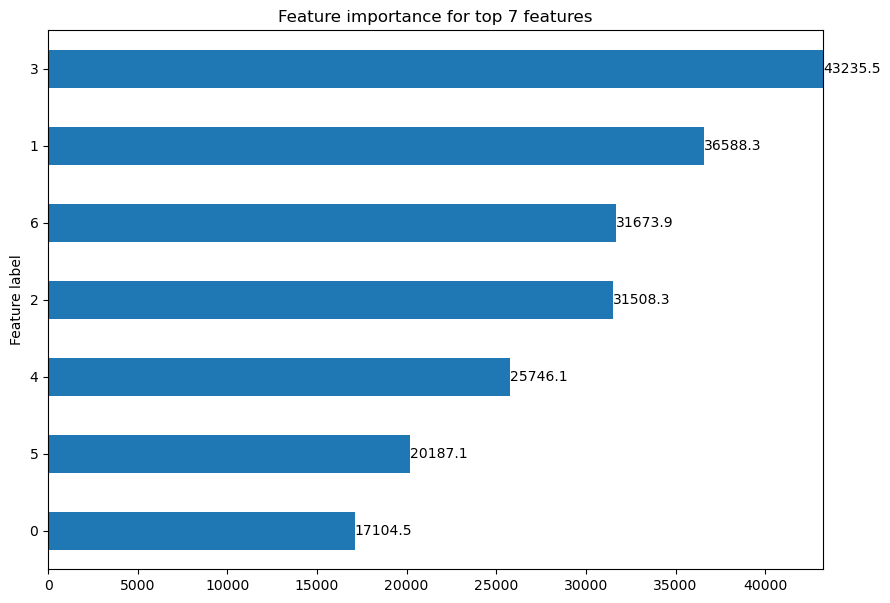

In [133]:
explanation.visualize_feature_importance(top_k=10)

In [8]:
# Train the first model: GCN, standard data, cross-entropy loss
training(model=gcn_model, data=data, optimizer=gcn_optimizer, epochs=50)

Epoch 0 | Loss: 0.5969341397285461
Epoch 10 | Loss: 0.5347746014595032
Epoch 20 | Loss: 0.46956467628479004
Epoch 30 | Loss: 0.42237937450408936
Epoch 40 | Loss: 0.3920229971408844


In [39]:
# Test the first model: GCN, standard data, cross-entropy loss
print("Here are the values for the standard GCN model with the standard cross-entropy loss: ")

metrics_base_gcn_model = test(gcn_model, data)

print_metrics(metrics_base_gcn_model)

Here are the values for the standard GCN model with the standard cross-entropy loss: 
Statistical Parity Difference : 0.04279
Statistical Parity Group with S=0 : 0.13590
Statistical Parity Group S=1 : 0.17869


Equal Opportunity Difference : 0.08792
Equal Opportunity Group with S=0 : 0.56215
Equal Opportunity Group S=1 : 0.47424


Overall Accuracy Equality Difference : 0.08489
Overall Accuracy Group with S=0 : 0.89029
Overall Accuracy Group S=1 : 0.80540


Treatment Equality Difference : 0.23409
Treatment Equality Group with S=0 : 5.26962
Treatment Equality Group S=1 : 5.03553


Accuracy : 0.85326


## Fair Models

In [9]:
from torch_scatter import scatter_add 

In [13]:
class FairnessAwareMessagePassingLayer(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(FairnessAwareMessagePassingLayer, self).__init__(aggr='mean')  
        self.lin = nn.Linear(in_channels, out_channels)
        self.a_fair = nn.Parameter(torch.rand(out_channels)) 
        self.sensitive_attr = torch.tensor(user_labels['bin_age'].values, dtype=torch.float) 
        self.bias_correction = nn.Parameter(torch.rand(1))

    def forward(self, x, edge_index):
        # Add self-loops 
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        x = self.lin(x)

        return self.propagate(edge_index, size=(x.size(0), x.size(0)), x=x)
    
    def message(self, x_j, edge_index, size):
        row, col = edge_index
        deg = degree(row, size[0], dtype=x_j.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        # Compute statistical parity difference for each edge
        group_difference = self.sensitive_attr[row] - self.sensitive_attr[col]
        
        # Adjust messages based on statistical parity
        fairness_adjustment = (1 + self.bias_correction * group_difference.view(-1, 1))

        return fairness_adjustment * norm.view(-1, 1) * x_j

    def update(self, aggr_out):
        return aggr_out

In [11]:
class custom_GCN(torch.nn.Module):
    def __init__(self, data):
        super(custom_GCN, self).__init__()
        self.conv1 = FairnessAwareMessagePassingLayer(data.num_node_features, 16)
        self.conv2 = FairnessAwareMessagePassingLayer(16, 2) # 2 output classes for gender

    def forward(self, x, edge_index, *args, **kwargs):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

### First Fair Model

This model is an instantiation of the `custom_GCN` using the standard cross-entropy loss.

In [146]:
model2 = custom_GCN(data)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.01)

# Train the model: Custom MP GNN, cross-entropy loss
training(model=model2, data=data, optimizer=optimizer2, epochs=50)

# Test the first FAIR model: CustomGNN, cross-entropy loss
print("Here are the values for the CustomGNN model with the standard NLL loss: ")

metrics_custom_gnn_model_1 = test(model2, data)

print_metrics(metrics_custom_gnn_model_1)

Epoch 0 | Loss: 0.6914186477661133
Epoch 10 | Loss: 0.689189076423645
Epoch 20 | Loss: 0.6863895058631897
Epoch 30 | Loss: 0.6826404333114624
Epoch 40 | Loss: 0.677354633808136
Here are the values for the CustomGNN model with the standard NLL loss: 
Statistical Parity Difference : 0.00653
Statistical Parity Group with S=0 : 0.02462
Statistical Parity Group S=1 : 0.03115


Equal Opportunity Difference : 0.01542
Equal Opportunity Group with S=0 : 0.11590
Equal Opportunity Group S=1 : 0.10048


Overall Accuracy Equality Difference : 0.09149
Overall Accuracy Group with S=0 : 0.81359
Overall Accuracy Group S=1 : 0.72210


Treatment Equality Difference : 1321.38330
Treatment Equality Group with S=0 : 887.95001
Treatment Equality Group S=1 : 2209.33325


False Negatives Group 1 : 19884.00000
False Positives Group 1 : 9.00000
False Negatives Group 0 : 17759.00000


False Positives Group 0 : 20.00000
Accuracy : 0.77420


In [151]:
def forward_with_sigmoid(input_data):
    return torch.sigmoid(model2(input_data))

from captum.attr import IntegratedGradients

ig = IntegratedGradients(forward_with_sigmoid)

attributions = ig.attribute(data.x, target=data.y)

import matplotlib.pyplot as plt

node_importances = attributions.mean(dim=0).detach().numpy()

plt.bar(np.arange(len(node_importances)), node_importances)
plt.ylabel('Importance')
plt.xlabel('Node Index')
plt.show()

TypeError: custom_GCN.forward() missing 1 required positional argument: 'edge_index'

In [148]:
explainer2 = Explainer(
    model=model2,
    algorithm=GNNExplainer(epochs=50),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='log_probs', 
    ),
)

explanation2 = explainer2(data.x, edge_index)
print(explanation2.edge_mask)
print(explanation2.node_mask)

explanation2.visualize_feature_importance(top_k=10)

AssertionError: 

In [24]:
print("Here are the values for the CustomGNN model with the standard NLL loss: ")

metrics_custom_gnn_model_1 = test(model2, data)

print_metrics(metrics_custom_gnn_model_1)

Here are the values for the CustomGNN model with the standard NLL loss: 
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Statistical Parity Difference : 0.09618
Statistical Parity Group with S=0 : 0.00055
Statistical Parity Group S=1 : 0.09672


Equal Opportunity Difference : 0.09554
Equal Opportunity Group with S=0 : 0.00069
Equal Opportunity Group S=1 : 0.09622


Overall Accuracy Equality Difference : 0.12325
Overall Accuracy Group with S=0 : 0.60343
Overall Accuracy Group S=1 : 0.48019


Treatment Equality Difference : 1444.01123
Treatment Equality Group with S=0 : 1454.23535
Treatment Equality Group S=1 : 10.22416


False Negatives Group 1 : 19978.00000
False Positives Group 1 : 1954.00000
False Negatives Group 0 : 49444.00000


False Positives Group 0 : 34.00000
Accuracy : 0.77192


In [43]:
model2 = custom_GCN(data)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.01)

# Train the model: Custom MP GNN, cross-entropy loss
training(model=model2, data=data, optimizer=optimizer2, epochs=50)

Epoch 0 | Loss: 0.6917305588722229
Epoch 10 | Loss: 0.6893579363822937
Epoch 20 | Loss: 0.6863116025924683
Epoch 30 | Loss: 0.6820639371871948
Epoch 40 | Loss: 0.6766539216041565


In [44]:
# Test the first FAIR model: CustomGNN, cross-entropy loss
print("Here are the values for the CustomGNN model with the standard cross-entropy loss: ")

metrics_custom_gnn_model_1 = test(model2, data)

print_metrics(metrics_custom_gnn_model_1)

Here are the values for the CustomGNN model with the standard cross-entropy loss: 
Statistical Parity Difference : 0.00867
Statistical Parity Group with S=0 : 0.02606
Statistical Parity Group S=1 : 0.03473


Equal Opportunity Difference : 0.00996
Equal Opportunity Group with S=0 : 0.12147
Equal Opportunity Group S=1 : 0.11151


Overall Accuracy Equality Difference : 0.08916
Overall Accuracy Group with S=0 : 0.81450
Overall Accuracy Group S=1 : 0.72534


Treatment Equality Difference : 543.08252
Treatment Equality Group with S=0 : 392.15555
Treatment Equality Group S=1 : 935.23810


Accuracy : 0.77683


### Second Fair Model

This model is an instantiation of the `custom_GCN` using the fair cross-entropy loss.

In [50]:
custom_gnn_model_2 = custom_GCN(data)
optimizer_custom_gnn_model_2 = torch.optim.Adam(custom_gnn_model_2.parameters(), lr=0.01)

fairness=True
alpha, beta, gamma, delta = 0.1, 0.1, 0.1, 0.1

# Train the model: Custom MP GNN, FAIR cross-entropy loss
training(model=custom_gnn_model_2, 
         data=data, 
         optimizer=optimizer_custom_gnn_model_2, 
         fairness=fairness, 
         alpha=alpha, 
         beta=beta, 
         gamma=gamma, 
         delta=delta, 
         epochs=50)

Epoch 0 | Loss: 0.41712942719459534
Epoch 10 | Loss: 0.4149610698223114
Epoch 20 | Loss: 0.4126940667629242
Epoch 30 | Loss: 0.40997573733329773
Epoch 40 | Loss: 0.4066038131713867


In [51]:
# Test the second FAIR model: CustomGNN, FAIR cross-entropy loss
print("Here are the values for the CustomGNN model with the FAIR standard cross-entropy loss: ")

metrics_custom_gnn_model_2 = test(custom_gnn_model_2, data)

print_metrics(metrics_custom_gnn_model_2)

Here are the values for the CustomGNN model with the FAIR standard cross-entropy loss: 
Statistical Parity Difference : 0.01379
Statistical Parity Group with S=0 : 0.04246
Statistical Parity Group S=1 : 0.05626


Equal Opportunity Difference : 0.02047
Equal Opportunity Group with S=0 : 0.19844
Equal Opportunity Group S=1 : 0.17797


Overall Accuracy Equality Difference : 0.08566
Overall Accuracy Group with S=0 : 0.83051
Overall Accuracy Group S=1 : 0.74486


Treatment Equality Difference : 56.19102
Treatment Equality Group with S=0 : 251.57812
Treatment Equality Group S=1 : 195.38710


Accuracy : 0.79366


### Third FAIR Model

This model is an instantiation of the `custom_GCN` using the fair cross-entropy loss using ONLY large treatment equality penalty.

In [56]:
custom_gnn_model_3 = custom_GCN(data)
optimizer_custom_gnn_model_3 = torch.optim.Adam(custom_gnn_model_3.parameters(), lr=0.01)

fairness=True
alpha, beta, gamma, delta = 0, 0.4, 0, 0

# Train the model: Custom MP GNN, FAIR cross-entropy loss
training(model=custom_gnn_model_3, 
         data=data, 
         optimizer=optimizer_custom_gnn_model_3, 
         fairness=fairness, 
         alpha=alpha, 
         beta=beta, 
         gamma=gamma, 
         delta=delta, 
         epochs=50)

Epoch 0 | Loss: 0.4166160225868225
Epoch 10 | Loss: 0.4148714542388916
Epoch 20 | Loss: 0.4131791591644287
Epoch 30 | Loss: 0.41099512577056885
Epoch 40 | Loss: 0.4082064926624298


In [57]:
# Test the third FAIR model: CustomGNN, FAIR cross-entropy loss with LARGE TE penalty
print("Here are the values for the CustomGNN model with the FAIR standard cross-entropy loss with LARGE TE penalty: ")

metrics_custom_gnn_model_3 = test(custom_gnn_model_3, data)

print_metrics(metrics_custom_gnn_model_3)

Here are the values for the CustomGNN model with the FAIR standard cross-entropy loss with LARGE TE penalty: 
Statistical Parity Difference : 0.01069
Statistical Parity Group with S=0 : 0.02339
Statistical Parity Group S=1 : 0.03409


Equal Opportunity Difference : 0.00013
Equal Opportunity Group with S=0 : 0.10997
Equal Opportunity Group S=1 : 0.10984


Overall Accuracy Equality Difference : 0.08737
Overall Accuracy Group with S=0 : 0.81232
Overall Accuracy Group S=1 : 0.72495


Treatment Equality Difference : 827.11365
Treatment Equality Group with S=0 : 812.63635
Treatment Equality Group S=1 : 1639.75000


Accuracy : 0.77486


### Fourth Fair Model

This model is going to use a different custom_GCN model, normal CE loss

In [8]:
# class CustomCELoss(nn.Module):
#     def __init__(self, sensitive_attr_weight=0.0):
#         super(CustomCELoss, self).__init__()
#         self.sensitive_attr_weight = sensitive_attr_weight
#         self.ce_loss = nn.CrossEntropyLoss()

#     def forward(self, input, target, sensitive_attr):
#         ce_loss = self.ce_loss(input, target)
#         reg_loss = self.sensitive_attr_weight * torch.mean(torch.abs(sensitive_attr))
#         total_loss = ce_loss + reg_loss
#         return total_loss
    
class CustomCELoss(nn.Module):
    def __init__(self, sensitive_attr_weight=0.0):
        super(CustomCELoss, self).__init__()
        self.sensitive_attr_weight = sensitive_attr_weight
        self.ce_loss = nn.CrossEntropyLoss()

    def forward(self, input, target, sensitive_attr):
        ce_loss = self.ce_loss(input, target)
        reg_loss = self.sensitive_attr_weight * torch.mean(torch.abs(sensitive_attr - 0.5))
        total_loss = ce_loss + reg_loss
        return total_loss
    

In [18]:
sensitive_attribute = torch.tensor(user_labels['bin_age'].values, dtype=torch.long)
sensitive_attribute = sensitive_attribute.float()

In [22]:
print(sensitive_attribute[data.train_mask])

print(data.x[data.train_mask, -1])

# calculate percentage of equal entries in the sensitive attribute and data.x
print(sensitive_attribute[data.train_mask].eq(data.x[data.train_mask, -1]).sum().item() / int(data.train_mask.sum()))

tensor([0., 1., 1.,  ..., 1., 1., 0.])
tensor([0., 1., 1.,  ..., 1., 0., 0.])
0.5527379722384439


In [15]:
# Train the model with customCE loss
def training_customCE(model, data, optimizer, epochs, sensitive_attr_weight):
    criterion = CustomCELoss(sensitive_attr_weight=sensitive_attr_weight)

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        out = model(data)
        # loss = criterion(out[data.train_mask], data.y[data.train_mask], data.x[data.train_mask, -1])
        loss = criterion(out[data.train_mask], data.y[data.train_mask], sensitive_attribute[data.train_mask])
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            print(f'Epoch {epoch} | Loss: {loss.item()}')


In [27]:
custom_gnn_model_4 = custom_GCN(data)
optimizer_custom_gnn_model_4 = torch.optim.Adam(custom_gnn_model_4.parameters(), lr=0.01)

sensitive_attr_weight = 0.01

# Train the model: Custom MP GNN, custom cross-entropy loss
training_customCE(model=custom_gnn_model_4, 
                  data=data, 
                  optimizer=optimizer_custom_gnn_model_4, 
                  epochs=50, 
                  sensitive_attr_weight=sensitive_attr_weight)

Epoch 0 | Loss: 0.6968374848365784
Epoch 10 | Loss: 0.6945965886116028
Epoch 20 | Loss: 0.6928642988204956
Epoch 30 | Loss: 0.6906540989875793
Epoch 40 | Loss: 0.6872914433479309


In [28]:
# Test the fourth FAIR model: CustomGNN, custom cross-entropy loss
print("Here are the values for the CustomGNN model with the custom cross-entropy loss: ")

metrics_custom_gnn_model_4 = test(custom_gnn_model_4, data)

print_metrics(metrics_custom_gnn_model_4)

Here are the values for the CustomGNN model with the custom cross-entropy loss: 


Statistical Parity Difference : 0.00362
Statistical Parity Group with S=0 : 0.00685
Statistical Parity Group S=1 : 0.01046


Equal Opportunity Difference : 0.00152
Equal Opportunity Group with S=0 : 0.03236
Equal Opportunity Group S=1 : 0.03388


Overall Accuracy Equality Difference : 0.09451
Overall Accuracy Group with S=0 : 0.79617
Overall Accuracy Group S=1 : 0.70166


Treatment Equality Difference : inf
Treatment Equality Group with S=0 : 6479.00000
Treatment Equality Group S=1 : inf


Accuracy : 0.75545


## Attention-based Message Passing

In this section, the models are trained using a custom attention-based message passing model.  
This custom attention should take the sensitive attribute into consideration when calculating the attention weights.

In [8]:
from torch_geometric.nn import GATConv

### Baseline GAT Models

In [11]:
# GAT class that takes in the data as an input for dimensions of the convolutions
class GAT(torch.nn.Module):
    def __init__(self, data):
        super(GAT, self).__init__()
        self.conv1 = GATConv(data.num_node_features, 16)
        self.conv2 = GATConv(16, 2) # 2 output classes for gender

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [12]:
# Instantiate the model, define loss function and optimizer
gat_model = GAT(data)
gat_optimizer = torch.optim.Adam(gat_model.parameters(), lr=0.01)

In [13]:
training(model=gat_model, data=data, optimizer=gat_optimizer, epochs=50)

Epoch 0 | Loss: 1.243209719657898
Epoch 10 | Loss: 0.6583862900733948
Epoch 20 | Loss: 0.5705628991127014
Epoch 30 | Loss: 0.5451962947845459
Epoch 40 | Loss: 0.5258474946022034


In [14]:
# Test the first model: GAT, standard data, cross-entropy loss
print("Here are the values for the standard GAT model with the standard cross-entropy loss: ")

metrics_base_gat_model = test(gat_model, data)

print_metrics(metrics_base_gat_model)

Here are the values for the standard GAT model with the standard cross-entropy loss: 
Statistical Parity Difference : 0.00537
Statistical Parity Group with S=0 : 0.00704
Statistical Parity Group S=1 : 0.01241


Equal Opportunity Difference : 0.00406
Equal Opportunity Group with S=0 : 0.02932
Equal Opportunity Group S=1 : 0.03339


Overall Accuracy Equality Difference : 0.09529
Overall Accuracy Group with S=0 : 0.79471
Overall Accuracy Group S=1 : 0.69941


Treatment Equality Difference : 95.33382
Treatment Equality Group with S=0 : 237.78049
Treatment Equality Group S=1 : 142.44667


Accuracy : 0.75287


Statistical Parity Difference : 0.00372
Statistical Parity Group with S=0 : 0.00472
Statistical Parity Group S=1 : 0.00844


Equal Opportunity Difference : 0.00493
Equal Opportunity Group with S=0 : 0.02235
Equal Opportunity Group S=1 : 0.02728


Overall Accuracy Equality Difference : 0.09448
Overall Accuracy Group with S=0 : 0.79409
Overall Accuracy Group S=1 : 0.69961


Treatment Equality Difference : 1864.00000
Treatment Equality Group with S=0 : 19638.00000
Treatment Equality Group S=1 : 21502.00000


Accuracy : 0.75335

### FairMP GAT Models

In [11]:
import torch
import torch.nn as nn
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops

class Attention_FairMessagePassing(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(Attention_FairMessagePassing, self).__init__(aggr='mean')
        self.lin = nn.Linear(in_channels, out_channels)
        self.att = nn.Linear(out_channels, 1)
        self.sensitive_attr = torch.tensor(user_labels['bin_age'].values, dtype=torch.float)
        self.bias_correction = nn.Parameter(torch.rand(1))

    def forward(self, x, edge_index):
        # Add self-loops
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        x = self.lin(x)
        x = self.propagate(edge_index, size=(x.size(0), x.size(0)), x=x)

        return x

    def message(self, x_i, x_j):
        # Calculate attention weights
        alpha = self.att(torch.abs(x_i - x_j))
        alpha = torch.exp(alpha) / (torch.exp(alpha).sum(dim=1, keepdim=True) + self.bias_correction)

        # Apply attention weights to messages
        return x_j * alpha

    def update(self, aggr_out):
        return aggr_out


In [12]:
# GAT class that takes in the data as an input for dimensions of the convolutions
class CustomGAT(torch.nn.Module):
    def __init__(self, data):
        super(CustomGAT, self).__init__()
        self.conv1 = Attention_FairMessagePassing(data.num_node_features, 16)
        self.conv2 = Attention_FairMessagePassing(16, 2) # 2 output classes for gender

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

#### First Fair GAT

In [21]:
# Instantiate the model, define loss function and optimizer
custom_gat_model = CustomGAT(data)
custom_gat_optimizer = torch.optim.Adam(custom_gat_model.parameters(), lr=0.01)

In [22]:
training(model=custom_gat_model, data=data, optimizer=custom_gat_optimizer, epochs=50)

Epoch 0 | Loss: 0.7300261855125427
Epoch 10 | Loss: 0.5912700891494751
Epoch 20 | Loss: 0.5659604668617249
Epoch 30 | Loss: 0.5476182103157043
Epoch 40 | Loss: 0.5287064909934998


In [23]:
# Test the first model: CustomGAT, standard data, cross-entropy loss
print("Here are the values for the CustomGAT model with the standard cross-entropy loss: ")

metrics_custom_gat_model = test(custom_gat_model, data)

print_metrics(metrics_custom_gat_model)

Here are the values for the CustomGAT model with the standard cross-entropy loss: 
Statistical Parity Difference : 0.00372
Statistical Parity Group with S=0 : 0.00472
Statistical Parity Group S=1 : 0.00844


Equal Opportunity Difference : 0.00493
Equal Opportunity Group with S=0 : 0.02235
Equal Opportunity Group S=1 : 0.02728


Overall Accuracy Equality Difference : 0.09448
Overall Accuracy Group with S=0 : 0.79409
Overall Accuracy Group S=1 : 0.69961


Treatment Equality Difference : 1864.00000
Treatment Equality Group with S=0 : 19638.00000
Treatment Equality Group S=1 : 21502.00000


Accuracy : 0.75335


#### Second Fair GAT

In [13]:
# Instantiate the model, define loss function and optimizer
custom_gat_model_2 = CustomGAT(data)
custom_gat_optimizer_2 = torch.optim.Adam(custom_gat_model_2.parameters(), lr=0.01)

In [14]:
training(model=custom_gat_model_2, data=data, optimizer=custom_gat_optimizer_2, fairness=True, beta=0.1, epochs=50)

Epoch 0 | Loss: 0.7302701473236084
Epoch 10 | Loss: 0.5995766520500183
Epoch 20 | Loss: 0.512322187423706
Epoch 30 | Loss: 0.48978760838508606
Epoch 40 | Loss: 0.46570953726768494


In [15]:
# Test the second model: CustomGAT, FAIR cross-entropy loss
print("Here are the values for the CustomGAT model with the FAIR cross-entropy loss: ")

metrics_custom_gat_model_2 = test(custom_gat_model_2, data)

print_metrics(metrics_custom_gat_model_2)

Here are the values for the CustomGAT model with the FAIR cross-entropy loss: 
Statistical Parity Difference : 0.01193
Statistical Parity Group with S=0 : 0.02863
Statistical Parity Group S=1 : 0.04057


Equal Opportunity Difference : 0.00700
Equal Opportunity Group with S=0 : 0.13417
Equal Opportunity Group S=1 : 0.12717


Overall Accuracy Equality Difference : 0.08810
Overall Accuracy Group with S=0 : 0.81727
Overall Accuracy Group S=1 : 0.72917


Treatment Equality Difference : 275.64874
Treatment Equality Group with S=0 : 483.11111
Treatment Equality Group S=1 : 207.46237


Accuracy : 0.77851
